## Initialize

In [1]:
import profile
from numpy import append
from selenium import webdriver
import time
import pandas as pd 
import json
import csv

Collect profile links of all HUST staffs and students

In [ ]:
def get_profile(url):
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(7)
    profiles = []
    list = driver.find_elements_by_css_selector('.nova-legacy-e-text--size-l a')
    for i in list:
        profiles.append(i.get_attribute('href'))
    driver.close()
    return(profiles)

In [ ]:
hust = 'https://www.researchgate.net/institution/Hanoi-University-of-Science-and-Technology/members'
total = []
for i in range(1,28):
    total += get_profile(hust+f'/{i}')
data = pd.DataFrame(total)
data.to_csv('profile.csv', index = False, header = False)

Read profile links of all HUST staffs and students

In [2]:
import csv

with open('profile.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

data[:10]

[['https://www.researchgate.net/profile/Michel-Toulouse'],
 ['https://www.researchgate.net/profile/Thi-Thao-Tran'],
 ['https://www.researchgate.net/profile/Nguyen-Anh-Tuan-4'],
 ['https://www.researchgate.net/profile/Vu-Hien-6'],
 ['https://www.researchgate.net/profile/Van-Truong-Pham'],
 ['https://www.researchgate.net/profile/Nguyen-Thi-Ngoc-Anh-7'],
 ['https://www.researchgate.net/profile/Viet-Thanh-Pham-2'],
 ['https://www.researchgate.net/profile/Thi-Le-5'],
 ['https://www.researchgate.net/profile/Thoan-Nguyen'],
 ['https://www.researchgate.net/profile/Thang-Huynh-Quyet']]

## Scraping

In [ ]:
#Start browser
scraped = []

driver = webdriver.Chrome()
driver.get('https://www.researchgate.net/login')

#Fill in login form
email = driver.find_element_by_id('input-login')
password = driver.find_element_by_id('input-password')

email.send_keys('tung.nq194462@sis.hust.edu.vn')
password.send_keys('abc123456')

login = driver.find_element_by_css_selector('.nova-legacy-c-button--color-blue.nova-legacy-c-button--theme-solid')
login.click()
time.sleep(1)

#Parse each personal profile
for url in data:
    url = url[0]
    driver.get(url)
    time.sleep(1)

    #Parse basic information
    name = driver.find_element_by_css_selector('.nova-legacy-e-text--size-xl').text
    tmp = driver.find_elements_by_css_selector('.nova-legacy-e-text div')
    researchInterest = tmp[0].text
    citation = tmp[1].text
    hindex = '--'
    if len(tmp)>2:
        hindex = tmp[2].text

    #parse skills and discipline
    disciplines = []
    skills = []
    sections = driver.find_elements_by_css_selector('.nova-legacy-e-text--spacing-xxs strong')
    s = [x.text for x in sections]  

    tmp1 = driver.find_elements_by_css_selector('.nova-legacy-c-card__body--spacing-m div.nova-legacy-o-stack__item:nth-of-type(1) li')
    tmp1 = [x.text for x in tmp1]
    if sections[0].text == 'Disciplines':
        disciplines = tmp1
    elif sections[0].text == "Skills and expertise":
        skills = tmp1

    if len(sections)>1:
        tmp2 = driver.find_elements_by_css_selector('.nova-legacy-c-card__body--spacing-m div:nth-of-type(2) li')
        tmp2 = [x.text for x in tmp2]
        if sections[1].text == 'Disciplines':
            disciplines = tmp2
        elif sections[1].text == "Skills and expertise":
            skills = tmp2

    if len(sections)>2: #if statement to avoid NoSuchElement error
        tmp3 = driver.find_elements_by_css_selector('.nova-legacy-c-card__body--spacing-m div:nth-of-type(3) li')
        tmp3 = [x.text for x in tmp3]
        if sections[2].text == "Skills and expertise":
            skills = tmp3
    

    
    #Parse following
    following = []
    try:
        viewbutton = driver.find_element_by_css_selector('.nova-legacy-o-stack__item:nth-child(1) .nova-legacy-c-card__footer-content .nova-legacy-c-button__label')
    except:
        viewbutton = 0
    if viewbutton:
        fl_num = driver.find_element_by_css_selector('div.nova-legacy-o-stack__item:nth-of-type(1) div.nova-legacy-e-text--color-grey-500').text
        fl_num = int(fl_num.split(' ')[-1][1:-1])
        viewbutton.click()
        time.sleep(0.5)
        list_following = driver.find_element_by_class_name('profile-follow-modal__modal-content')
        for j in range(fl_num//10):
            driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", list_following)
            time.sleep(0.5)
        tmp = driver.find_elements_by_css_selector('span span .nova-legacy-e-text--color-inherit a')
        for e in tmp:
            l = e.get_attribute('href')
            l = l.split('?')[0]
            if l != url and [l] in data:
                following.append(l)

    time.sleep(0.5)
    # Parse RG score
    rgscore = 0
    tmp = driver.find_elements_by_css_selector('a.nova-legacy-c-nav__item')
    if len(tmp) >2:
        driver.get(url+'/scores')
        rgscore = driver.find_element_by_css_selector('.rg-score-section-inner div.number').text
    
    final_profile = {'url': url, 'name': name, 'research_interest': researchInterest, 
                    'citation': citation, 'h-index': hindex, 'RG score': rgscore,
                    'disciplines': disciplines, 'skills': skills, 'following':following}
    scraped.append(final_profile)


with open('final_data.json', 'w', encoding='utf-8') as f:
    json.dump(scraped, f, ensure_ascii=False, indent = 4)


In [3]:
with open('final/basic_profiles.json', encoding='utf-8' ) as f:
    profiles = json.load(f)

with open('final/relationship.csv', encoding='utf-8') as f:
    reader = csv.reader(f)
    relationship = list(reader)



In [6]:
#Graph creating
import networkx as nx 
G = nx.DiGraph()
for p in profiles:
    G.add_node(p['url'], name=p['name'],research_interest=p['research_interest'], 
    citation=p['citation'], h_index = p['h-index'], RG_score= p['RG score'] )
for r in relationship:
    G.add_edge(r[0],r[1])

nx.write_graphml(G, 'graph/rgdata.graphml', encoding='utf-8')
nx.write_gml(G, 'graph/rgdata.gml')
nx.write_gexf(G, 'graph/rgdata.gexf')
    

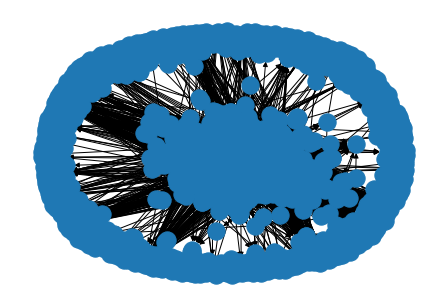

In [ ]:
    # # Parse research page
    # driver.get(url+'/research')
    # SCROLL_PAUSE_TIME =1

    # # Get scroll height
    # last_height = driver.execute_script("return document.body.scrollHeight")

    # while True:
    #     # Scroll down to bottom
    #     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    #     # Wait to load page
    #     time.sleep(SCROLL_PAUSE_TIME)

    #     # Calculate new scroll height and compare with last scroll height
    #     new_height = driver.execute_script("return document.body.scrollHeight")
    #     if new_height == last_height:
    #         break
    #     last_height = new_height

    # tmp4= driver.find_elements_by_css_selector('.nova-legacy-e-text--size-l a')
    # researchs = [x.get_attribute('href') for x in tmp4]
    # author_links = []
    # for link in researchs:
    #     driver.get(link)
        


    #     try:
    #         button = driver.find_element_by_css_selector('.nova-legacy-e-list__item button')
    #         button.click()
    #     except:
            
    #         tmp5 = driver.find_elements_by_css_selector('a.research-detail-author')
    #         for e in tmp5:
    #             l = e.get_attribute('href')
    #             l = l.split('?')[0]
    #             if l != url and [l] in data:
    #                 author_links.append(l)

In [9]:
## Work with files
#profiles = []
# with open('final_data.json', 'w', encoding='utf-8') as f:
#     json.dump(profiles, f, ensure_ascii=False, indent = 4)
# errors = []
# for p in data:
#     if p[0] not in success:
#         errors.append(p[0])
# print(len(errors))

# relationship = []
# for p in profiles:
#     for url in p['following']:
#         relationship.append([p['url'], url])
# relationship = pd.DataFrame(relationship)
# relationship.to_csv('relationship.csv',index=False,header=False)

# for p in profiles:
#     del p['disciplines']
#     del p['skills']
# with open('final/basic_profiles.json','w', encoding='utf-8') as f:
#     json.dump(profiles,f,ensure_ascii=False,indent=4)